In [4]:
import pandas as pd
import numpy as np
from scipy import optimize
import os
import json
from matplotlib import pyplot as plt
import matplotlib
import pickle as pkl
from statsmodels.stats.anova import AnovaRM
from pylab import *
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

In [5]:
param_names = [
                 'num_trains',
                 'qf_lr',

               ]
param_full_names = [
                 'algorithm_args/num_trains_per_train_loop',
                 'qf_lr',

                    ]
result_names = [
                'expl_num_correct',
                'expl_successes',
                'expl_noop',

                'qf_loss',
                'Q_values_mean',
                'Q_values_std',

                ]
result_full_names = [
                     'exploration/env_infos/num_correct_Mean',
                     'exploration/env_infos/final/task_success_Mean',
                     'exploration/env_infos/noop_Mean',
                    'trainer/QF_Loss',
                    'trainer/Q_Predictions_Mean',
                    'trainer/Q_Predictions_Std',
                    ]


In [6]:
class Reader:
    def read_csv(self,paths,name='pretrain.csv'):
        dfs = []
        for path in paths:
            try:
                df = pd.read_csv(os.path.join(path,name))
                dfs.append(df)
            except:
                continue
        return dfs
    
    def read_pkl(self, paths, name='metrics.pkl'):
        data = []
        for path in paths:
            try:
                with open(os.path.join(path, name), 'rb') as f:
                    data.append(pkl.load(f))
            except:
                continue
        return data

    
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens), len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l), idx] = l
    return arr.mean(axis=-1), arr.std(axis=-1) / np.sqrt(len(arrs))

def smooth(x):
    return np.convolve(x, np.ones(window) / window, 'valid')


def get_dfs(tests):
    paths = []
    for test in tests:
        root_path = os.path.join(os.path.abspath(''), 'logs', test)
        test_paths = [os.path.join(root_path, run) for run in os.listdir(root_path)]
        test_paths = sorted(test_paths)
        paths.extend(test_paths)

    dfs = Reader().read_csv(paths, name='progress.csv')
    for df in dfs:
        df.columns = df.columns.get_level_values(0)
    return dfs

def get_metrics(test):
    root_path = os.path.join(os.path.abspath(''), 'logs', test)
    paths = [os.path.join(root_path, run) for run in os.listdir(root_path)]
    paths = sorted(paths)
    
    return Reader().read_pkl(paths, name='metrics.pkl')


def csv_to_metrics(path):
    metrics = {'success_episodes': [],
               'episode_lengths': [],
               'success_blocks': [],
               'block_lengths': [],
               'correct_rewards': [],
               'correct_blocks': []
              }

    
    df = Reader().read_csv([path], name='progress.csv')[0]
    data = df.filter(items=result_full_names).to_dict(orient='list')
    
    failures = 0
    for i, row in df.iterrows():
        real_success = row['exploration/env_infos/final/task_success Max']
        if i == len(df) - 1:
            success = real_success
        else:
            # key = 'exploration/env_infos/initial/switch_pos Mean'
            key = 'exploration/env_infos/initial/shelf_pos Mean'
            success = not row[key] == df.iloc[i + 1][key]
            
        path_length = row['exploration/path length Mean']
        if path_length == 200 and not real_success:
            metrics['correct_rewards'].append(None)
        else:
            metrics['correct_rewards'].append(success)
        
        if not success:
            failures += 1
        
        block_timeout = failures >= 5
        if success or block_timeout or i == len(df) - 1:
            metrics['success_blocks'].append(real_success)
            metrics['block_lengths'].append(failures + int(success))
            metrics['correct_blocks'].append(block_timeout or real_success)
            failures = 0
        
        metrics['success_episodes'].append(real_success)
        metrics['episode_lengths'].append(path_length)
        
    with open(os.path.join(path, 'metrics.pkl'), 'wb') as f:
        pkl.dump(metrics, f)

In [7]:
# csv_to_metrics(os.path.join(os.path.abspath(''), 'logs', 'user_study', 'bottle', 'C', '7'))

In [8]:
def plot(title, metric, *args, font_size=26, aux_results=True, ablation=False, figsize=(16, 9), framealpha=None,
         legend=True, bbox_to_anchor=None):
    matplotlib.rcParams.update({'font.size': font_size})
    
    average_stats = {}
    average_results = {}
    anova_results = []
    # anova_shift_results = []
    total_accuracy_by_attempt = {}
    fig, ax = plt.subplots(figsize=figsize)

    for results, label, color in args:
        total_accuracy_by_attempt[label] = []

        if metric == 'block_lengths':
            data = []
            aux_data = []
            accuracy_by_attempt = [[], [], [], [], []]

            for result in results:
                n_eps = len(result['success_episodes'])
                block_lengths_per_block = []
                xs = []
                block_lengths = result[metric]
                success_blocks = result['success_blocks']
                index = 0
                for length, success in zip(block_lengths[:-1], success_blocks):
                    failures = length - int(success)
                    block_lengths_per_block.append(failures)
                    xs.append(index)
                    index += length
                    for i in range(failures):
                        accuracy_by_attempt[i].append(0)
                    if failures < 5:
                        accuracy_by_attempt[failures].append(1)

                # if last block was not cut short early
                if success_blocks[-1] or block_lengths[-1] == 5:
                    failures = block_lengths[-1] - int(success_blocks[-1])
                    block_lengths_per_block.append(failures)
                    xs.append(index)
                    for i in range(failures):
                        accuracy_by_attempt[i].append(0)
                    if failures < 5:
                        accuracy_by_attempt[failures].append(1)

                aux_data.append(block_lengths_per_block)

                if 'Random' not in label:
                    block_lengths_per_episode = np.interp(np.arange(n_eps), xs, 
                                                          block_lengths_per_block)
                    data.append(block_lengths_per_episode)

                else:
                    data.append(np.full(n_eps, np.mean(block_lengths_per_block)))

                total_accuracy_by_attempt[label].append([np.mean(x) for x in accuracy_by_attempt])
        elif metric == 'success_episodes':
            data = []
            aux_data = []

            for result in results:
                n_eps = len(result['success_episodes'])
                first_successes = []
                xs = []
                block_lengths = result['block_lengths']
                success_episodes = result['success_episodes']
                index = 0
                for length in block_lengths:
                    first_successes.append(success_episodes[index])
                    xs.append(index)
                    index += length

                aux_data.append(first_successes)

                if 'Random' not in label:
                    first_successes_per_episode = np.interp(np.arange(n_eps), xs, 
                                                            first_successes)
                    data.append(first_successes_per_episode)
                else:
                    data.append(np.full(n_eps, np.mean(first_successes)))


#                 data = [[float(x) for x in result[metric]] for result in results if metric in result.keys()]
#                 aux_data = data
        
        elif metric == 'path_length_successes':
            data = []
            aux_data = []
            for result in results:
                n_eps = len(result['success_episodes'])
                path_length_successes = []
                xs = []
                success_episodes = result['success_episodes']
                episode_lengths = result['episode_lengths']
                index = 0
                for i in range(n_eps):
                    if success_episodes[i]:
                        path_length_successes.append(episode_lengths[i])
                        xs.append(i)

                aux_data.append(path_length_successes)

                if 'Random' not in label:
                    path_length_successes_per_episode = np.interp(np.arange(n_eps), xs, path_length_successes)
                    data.append(path_length_successes_per_episode)
                else:
                    data.append(np.full(n_eps, np.mean(path_length_successes)))

                    
        else:
            data = aux_data = [np.abs(result[metric]) for result in results]

        average_results[label] = [np.mean(x) for x in aux_data]
        smoothed_data = [smooth(x) for x in data]
        average_stats[label] = {'mean': np.mean(average_results[label]),
                                'std_error': np.std(average_results[label]) 
                                / np.sqrt(len(average_results[label]))}

        asha_labels = ['Non-Adaptive (Baseline)', 'ASHA (Ours)']
        for i, x in enumerate(average_results[label]):
            if label in asha_labels:
                anova_results.append([x, i, label])
#                 if 'Baseline' in label or 'Shift' in label:
#                     anova_shift_results.append([x, i, label])

        if len(data) > 0:
            marker = '--' if 'Random' in label else '-'
            mean, std_error = tolerant_mean(smoothed_data)
            plt.plot(mean, label=label, c=color, linewidth=3, ls=marker)
            plt.fill_between(np.arange(len(mean)), mean-std_error, mean+std_error, color=color, alpha=0.1)

    table = pd.DataFrame.from_dict(average_stats, orient='index')
    if metric == 'success_episodes':
        ylabel = 'First Attempt Task Success Rate'
        ylim = (0, 1) if ablation else (0, 1)
        leg_loc = 'upper right'#'lower right' if ablation else 'upper left'
    elif metric == 'block_lengths':
        ylabel = 'Number of Failed Attempts Per Task'
        ylim = (0, 5.5) if ablation else (0, 5)
        leg_loc = 'lower left'#'upper right' if ablation else 'lower left'
    else:
        ylabel = metric
        ylim = None
        leg_loc = None
    
    plt.title(title)
    plt.xlabel('Number of Online Episodes')
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    
    
    if legend:
        leg = plt.legend(loc=leg_loc, framealpha=framealpha,
                        bbox_to_anchor=bbox_to_anchor)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3) 

    file_title = title.replace('/', '').replace('.', '')
    file_name = file_title + '_' + metric + '.pdf'
    if ablation:
        file_name = 'ablation_' + file_name
    plt.savefig(file_name)

    if metric == 'block_lengths' and not ablation:
        fig, ax = plt.subplots(figsize=(9, 9))

        for _, label, color in args:
            mean, std_error = tolerant_mean(total_accuracy_by_attempt[label])
            plt.plot(np.arange(len(mean)) + 1, mean, label=label, c=color, linewidth=3)
            plt.fill_between(np.arange(len(mean)) + 1, mean-std_error, mean+std_error, color=color, alpha=0.1)

        plt.title(title)
        plt.xlabel('Attempt Number')
        plt.ylabel('Task Success Rate')
        plt.ylim((0, 1))
        plt.xticks(np.arange(5) + 1)
        
        if legend:
            leg = plt.legend()
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3)

        plt.savefig(file_title + '_accuracy_by_attempt.pdf')

    print(title, metric)
    print(table)
    if aux_results:
        anova_table = pd.DataFrame.from_records(anova_results, columns=[metric, 'user', 'method'])
        aovrm = AnovaRM(data=anova_table, depvar=metric, subject='user', within=['method'])
        res = aovrm.fit()
        print(res)
            
#             anova_shift_table = pd.DataFrame.from_records(anova_shift_results, columns=[metric, 'user', 'method'])
#             aovrm_shift = AnovaRM(data=anova_shift_table, depvar=metric, subject='user', within=['method'])
#             res_shift = aovrm_shift.fit()
#             print(res_shift)

def plot_scatter(metric, *args, scatter_indices=None):
    matplotlib.rcParams.update({'font.size': 20})
    
    plt.figure(figsize=(9, 9))
    average_results = {'Bottle': {}, 'Switch': {}}

    for results, env, cond in args:
        if metric == 'block_lengths':
            data = []
            aux_data = []
            for result in results:
                block_lengths_per_block = []
                block_lengths = result[metric]
                success_blocks = result['success_blocks']
                for length, success in zip(block_lengths[:-1], success_blocks):
                    failures = length - int(success)
                    block_lengths_per_block.append(failures)

                # if last block was not cut short early
                if success_blocks[-1] or block_lengths[-1] == 5:
                    block_lengths_per_block.append(failures)

                data.append(block_lengths_per_block)
        else:
            data = [[float(x) for x in result[metric]] for result in results if metric in result.keys()]

        average_results[env][cond] = [np.mean(x) for x in data]

    for env in ['Switch', 'Bottle']:
        baseline_means = np.array(average_results[env]['baseline'])
        asha_means = np.array(average_results[env]['asha'])
        color = 'tab:orange' if env == 'Switch' else 'tab:cyan'

#         if scatter_indices is not None:
#             plt.scatter(baseline_means[scatter_indices], asha_means[scatter_indices], color='color, s=200)
#             plt.vlines(baseline_means[scatter_indices], baseline_means[scatter_indices],
#                        asha_means[scatter_indices], color=color, linestyle="dotted")
#             plt.scatter(np.delete(baseline_means, scatter_indices), 
#                         np.delete(asha_means, scatter_indices), color='tab:cyan', s=200)
#             plt.vlines(np.delete(baseline_means, scatter_indices), np.delete(baseline_means, scatter_indices),
#                        np.delete(asha_means, scatter_indices), color='tab:cyan', linestyle="dotted")
#         else:

        plt.scatter(baseline_means, asha_means, color=color, s=200, label=env)
        plt.vlines(baseline_means, baseline_means, asha_means, color=color,
               linestyle="dotted")

    plt.plot([0, 5], [0, 5], c='tab:gray', linestyle='dashed')
    lim, xlabel, ylabel = {'success_episodes': ([0, 1], 'First Attempt Success Rate of Non-Adaptive Interface (Baseline)',
                                               'First Attempt Success Rate of ASHA (Our Method)'),
                           'block_lengths': ([0, 5], 'Average # Failed Attempts of Non-Adaptive Interface (Baseline)',
                                               'Average # Failed Attempts of ASHA (Our Method)')}[metric]

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    leg = plt.legend()

    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)

    plt.xlim(lim)
    plt.ylim(lim)
    plt.savefig(metric + '_scatter.pdf', bbox_inches='tight')

0.9869319869319869
Bottle success_episodes
                              mean  std_error
ASHA (Ours)               0.738813   0.048971
Non-Adaptive (Baseline)   0.646585   0.041816
Random Latent (Baseline)  0.491223   0.023624
               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  7.2827 1.0000 11.0000 0.0207

Switch success_episodes
                              mean  std_error
ASHA (Ours)               0.525924   0.046578
Non-Adaptive (Baseline)   0.413113   0.040169
Random Latent (Baseline)  0.204520   0.024163
               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  8.2638 1.0000 11.0000 0.0151

Bottle w/ Env. Shift success_episodes
                              mean  std_error
ASHA (Ours)               0.669973   0.064092
Random Latent (Baseline)  0.491223   0.023624
Switch w/ Task Shift success_episodes
                              mean  std_error
ASHA (Ours)               0.369735   0.

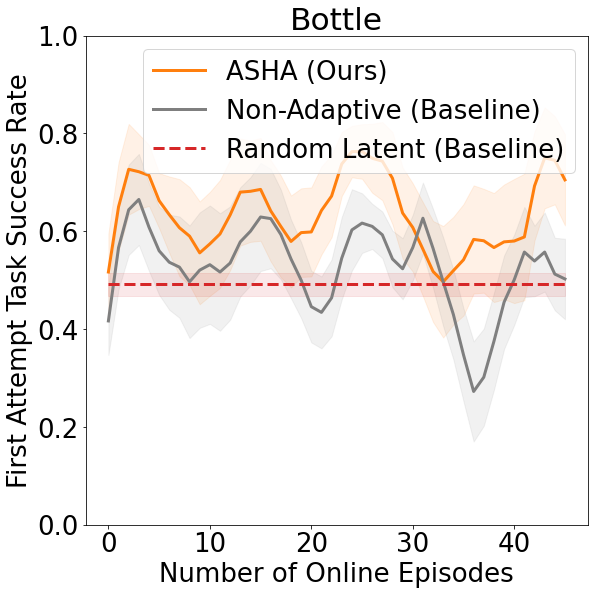

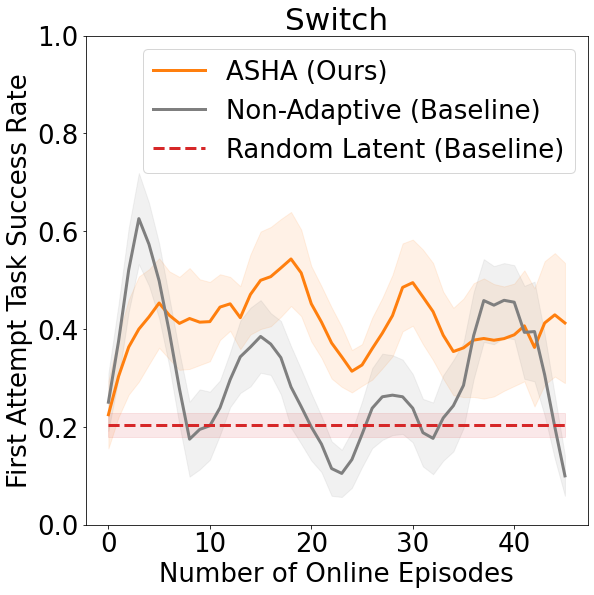

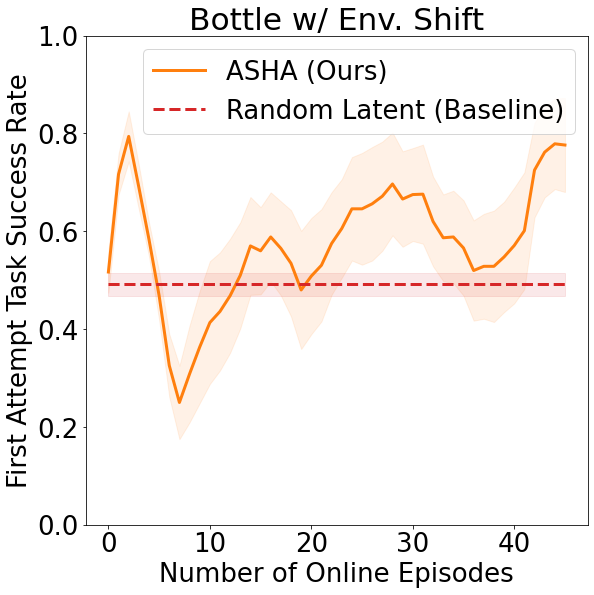

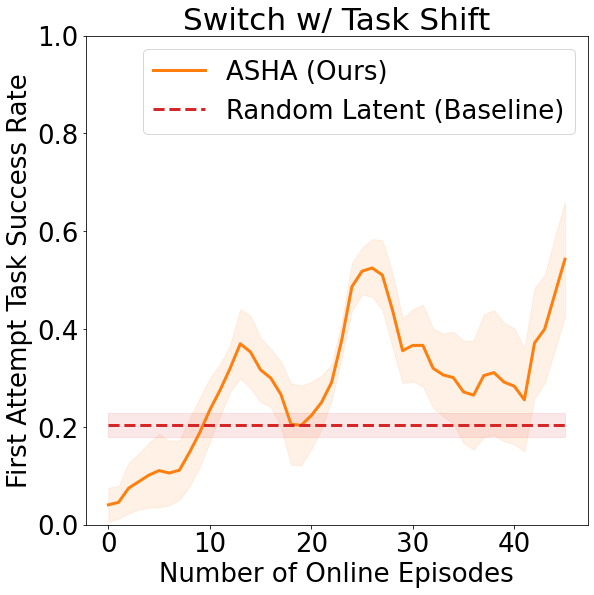

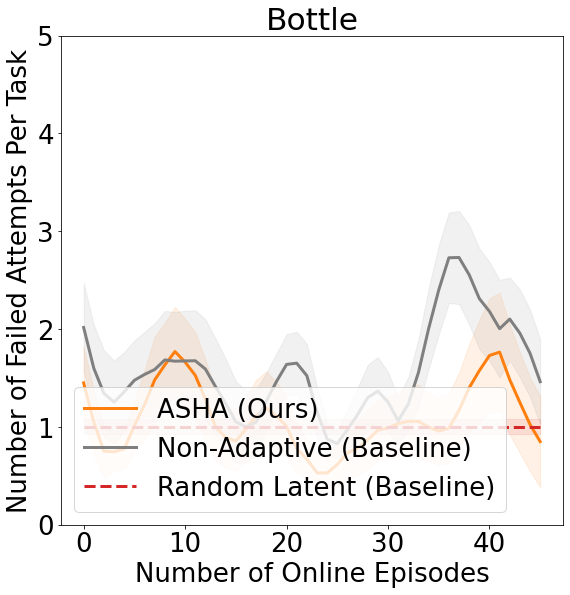

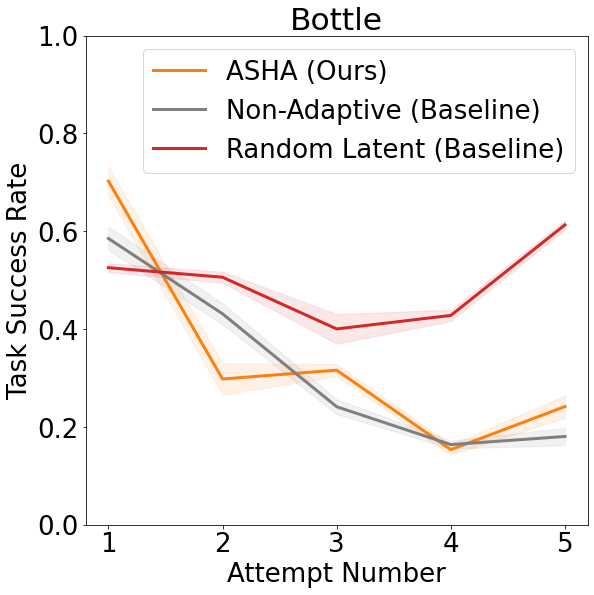

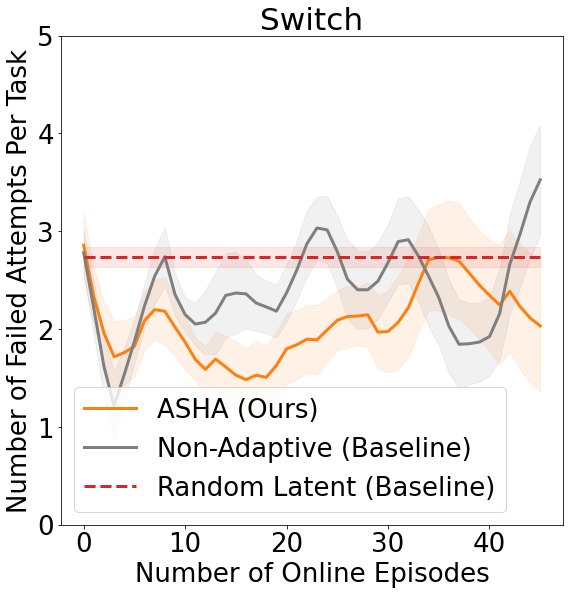

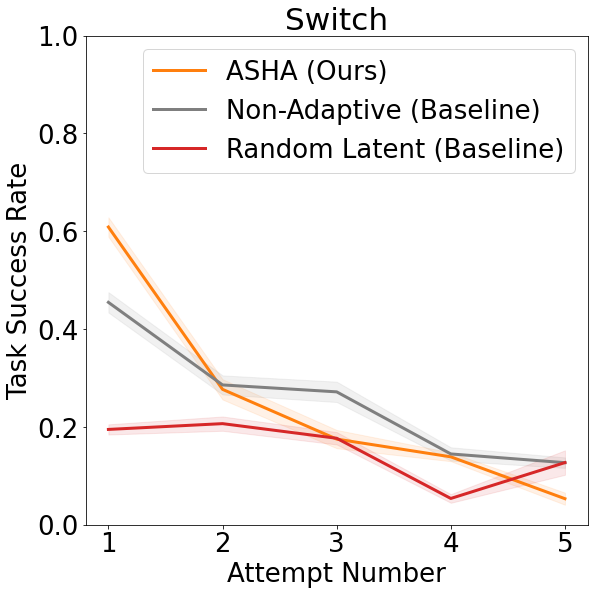

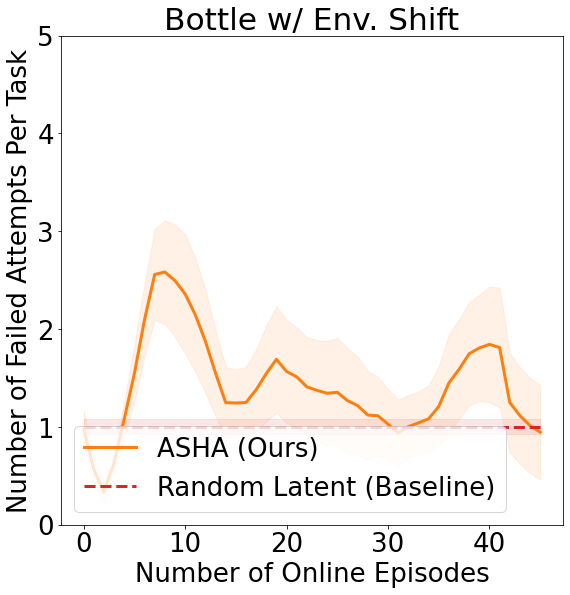

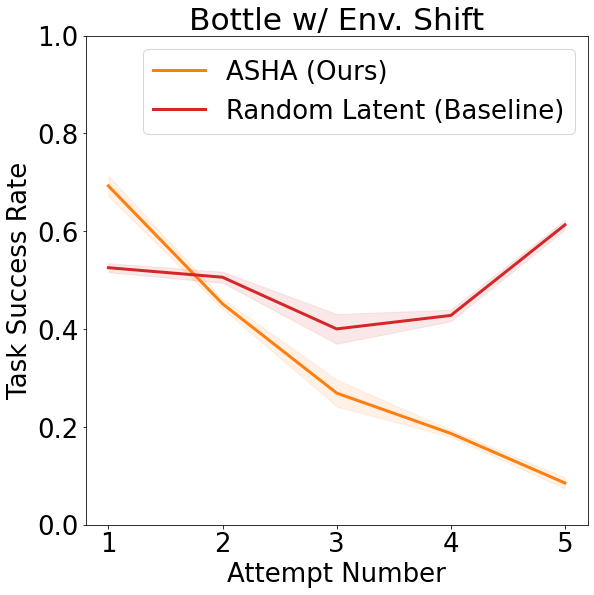

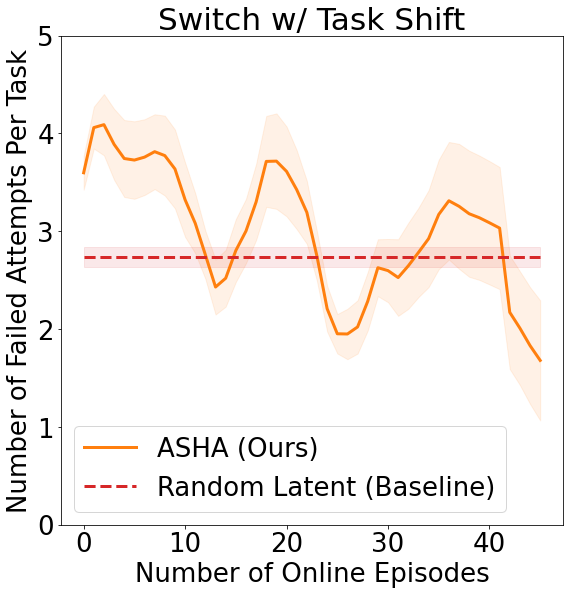

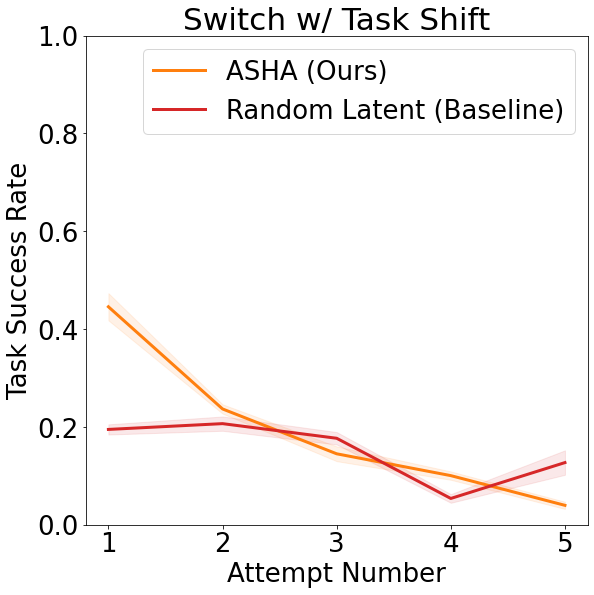

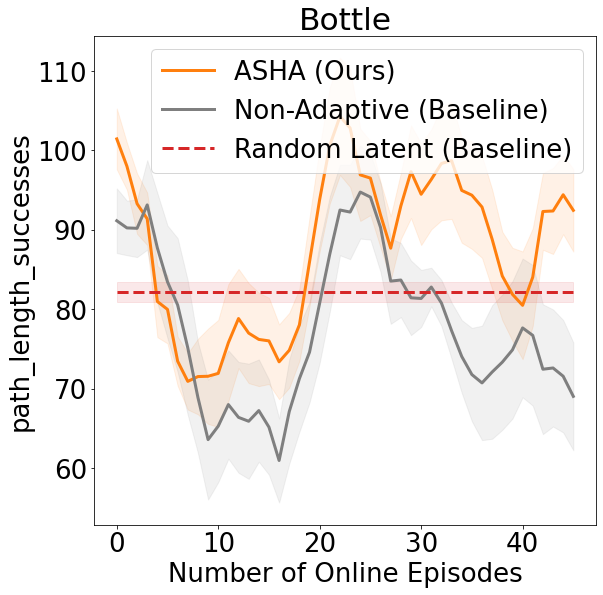

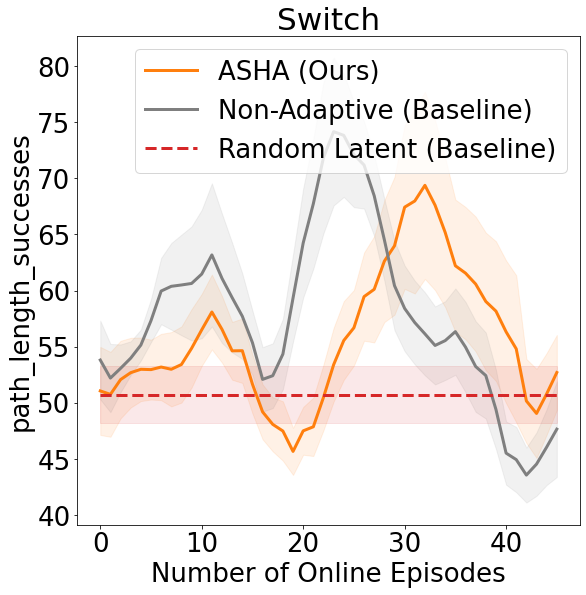

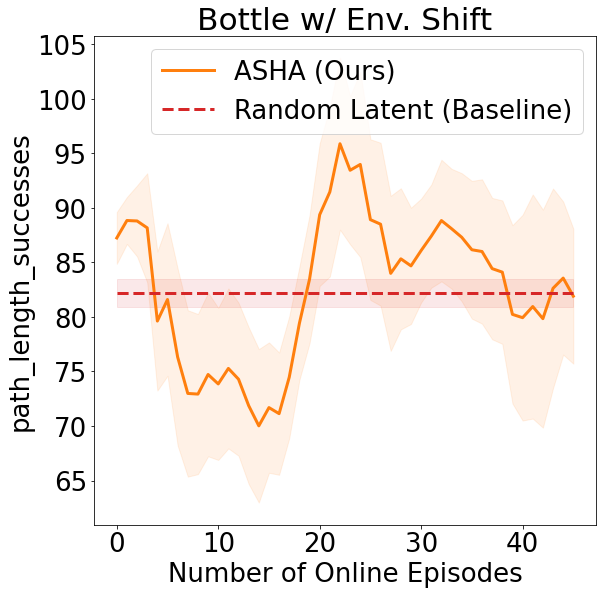

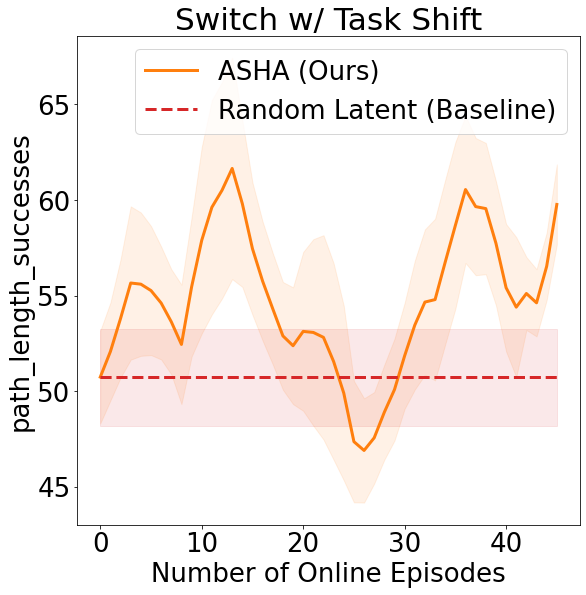

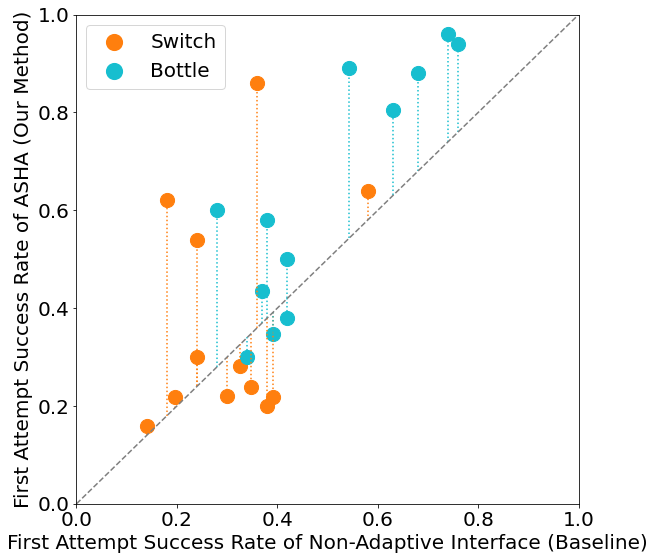

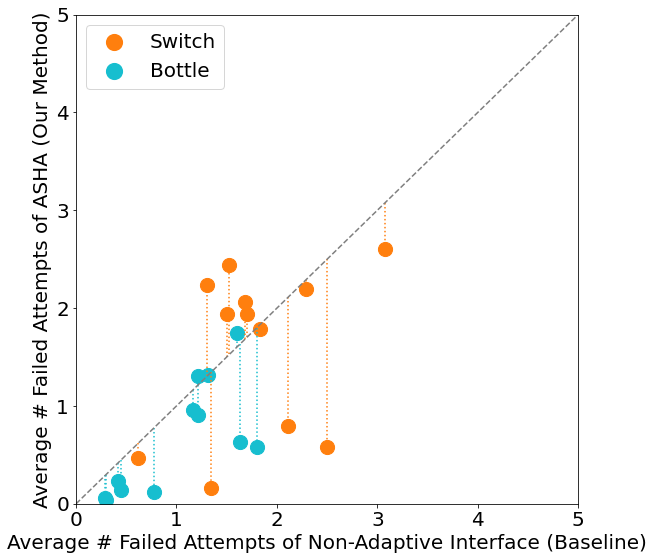

In [9]:
data = {}
correct_rewards = []
for env in ['bottle', 'switch']:
    for cond in ['A', 'B', 'C', 'RandLatent']:
        data[env + cond] = get_metrics('user_study/' + env + '/' + cond)
        if cond is not 'RandLatent':
            for user in data[env + cond]:
                correct_rewards.extend([x for x in user['correct_rewards'] if x is not None])

print(np.mean(correct_rewards))

bottleA = data['bottleA'], 'Non-Adaptive (Baseline)', 'tab:gray'
bottleB = data['bottleB'], 'ASHA (Ours)', 'tab:orange'
bottleC = data['bottleC'], 'ASHA (Ours)', 'tab:orange'
bottleRandLatent = data['bottleRandLatent'], 'Random Latent (Baseline)', 'tab:red'
switchA = data['switchA'], 'Non-Adaptive (Baseline)', 'tab:gray'
switchB = data['switchB'], 'ASHA (Ours)', 'tab:orange'
switchC = data['switchC'], 'ASHA (Ours)', 'tab:orange'
switchRandLatent = data['switchRandLatent'], 'Random Latent (Baseline)', 'tab:red'

metrics = ['success_episodes', 'block_lengths', 'path_length_successes']


window = 5

bottle_constant_indices = [1, 3, 5, 6, 7]
bottle_ontarget_indices = [0, 2, 3, 6]

switch_constant_indices = [0, 1]
switch_ontarget_indices = [1]

for metric in metrics:
    figsize = (9, 9)
    
    plot('Bottle', metric, bottleB, bottleA, bottleRandLatent, figsize=figsize)
    plot('Switch', metric, switchB, switchA, switchRandLatent, figsize=figsize)

    plot('Bottle w/ Env. Shift', metric, bottleC, bottleRandLatent, figsize=(9, 9), aux_results=False)
    plot('Switch w/ Task Shift', metric, switchC, switchRandLatent, figsize=(9, 9), aux_results=False)

bottleA = data['bottleA'], 'Bottle', 'baseline'
bottleB = data['bottleB'], 'Bottle', 'asha'
switchA = data['switchA'], 'Switch', 'baseline'
switchB = data['switchB'], 'Switch', 'asha'

for metric in metrics:
    if metric is not 'path_length_successes':
        plot_scatter(metric, bottleA, bottleB, switchA, switchB)

dfs = pd.concat(get_dfs(['user_study/bottle/A', 'user_study/bottle/B', 'user_study/bottle/C', 
                         'user_study/switch/A', 'user_study/switch/B', 'user_study/switch/C']))
print(dfs.loc[:, 'time/exploration sampling (s)'].mean())


sets = [[data['bottleA'], data['bottleB'], data['bottleC']], [data['switchA'], data['switchB'], data['switchC']]]

for x in sets:
    total = 0
    timeouts = 0
    for results in x:
        for result in results:
            for length, success in zip(result['block_lengths'], result['success_blocks']):
                if length == 5 and not success:
                    timeouts += 1
                total += 1
    print(timeouts / total)





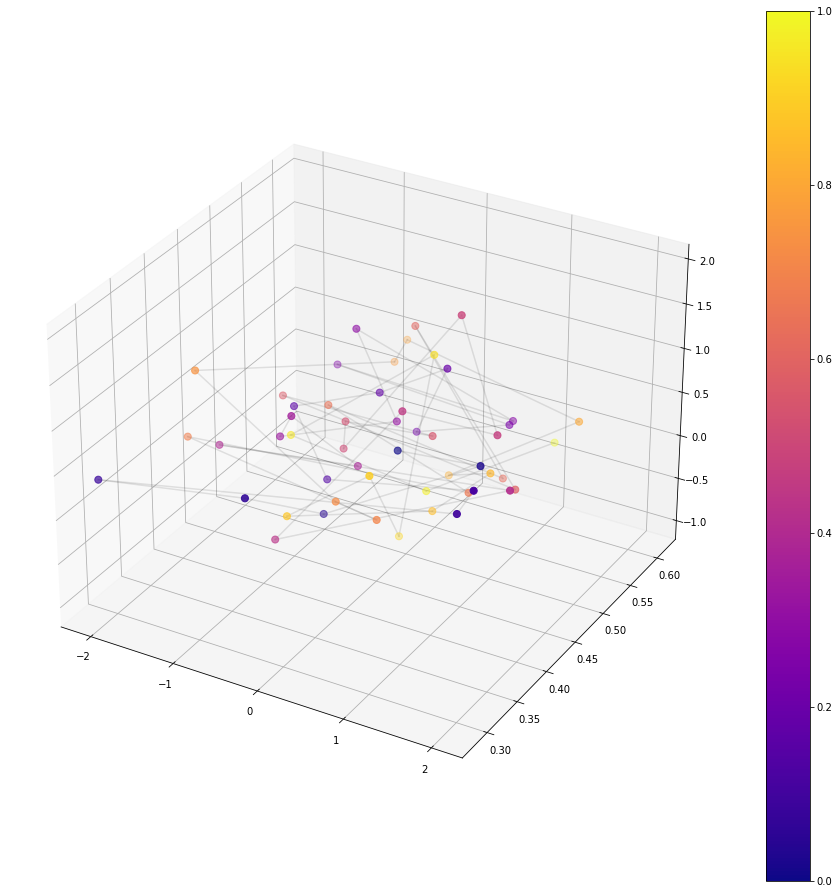

In [5]:
def plot_latents(env, user, target, index):
    data_path = os.path.join(os.path.abspath(''), 'logs', 'user_study', env, 'C', user, 'data.pkl')
    with open(data_path, 'rb') as f:
        data = pkl.load(f)
    latents = []
#     num_eps = 0
#     for block in data:
#         if block[0]['env_infos'][-1]['target_index'] == target:
#             for eps in block:
#                 latents.extend([np.concatenate((obs['latents'], [num_eps])) for obs in eps['observations']])
#                 num_eps += 1

    for block in data:
        if block[0]['env_infos'][-1]['target_index'] == target:
            for eps in block:
                for eps in block:
                    latents.append([np.concatenate((obs['latents'], [i])) 
                                    for i, obs in enumerate(eps['observations'])])
                
    latents = np.array(latents[index])
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111,projection='3d')
    
    xs = latents[:, 0]
    ys = latents[:, 1]
    zs = latents[:, 2]
    time = latents[:, 3]

    colmap = cm.ScalarMappable(cmap=cm.plasma)
    #colmap.set_array(time)

    yg = ax.scatter(xs, ys, zs, c=cm.plasma(time/max(time)), marker='o', s=50)
    cb = fig.colorbar(colmap)
    
    for i in range(len(xs) - 1):
        ax.plot([xs[i],xs[i+1]],[ys[i],ys[i+1]],[zs[i],zs[i+1]], color='k', alpha=0.1)
    
    plt.show()

                    
plot_latents('switch', '3', 1, 3)


In [7]:
metrics = ['success_episodes', 'block_lengths', 'path_length_successes']

for exp in ['switch-ablations/', 'bottle-ablations/']:
    asha = get_metrics(exp + 'asha'), 'ASHA (Ours)', 'tab:orange'
    no_online = get_metrics(exp + 'no-online'), 'Non-Adaptive (Baseline)', 'tab:gray'
    rand_latent = get_metrics(exp + 'rand-latent'), 'Random Latent (Baseline)', 'tab:red'
    awr = get_metrics(exp + 'awr'), 'ASHA w/ Latent Regression', 'tab:cyan'
    scratch = get_metrics(exp + 'scratch'), 'SAC from Scratch (Baseline)', 'tab:blue'
    no_relabeling = get_metrics(exp + 'no-relabeling'), 'ASHA w/o Failure Relabeling', 'tab:purple'
    deterministic = get_metrics(exp + 'deterministic'), 'ASHA w/ Deterministic Input Encoder', 'tab:pink'
    deterministic_pretrain = get_metrics(exp + 'deterministic-pretrain'), 'ASHA w/ Deterministic Pretrain Encoder', 'tab:green'
        
    window = 5
    title = 'Switch' if 'switch' in exp else 'Bottle'
    for metric in metrics:
        plot(title, metric, rand_latent, no_online, asha, deterministic, deterministic_pretrain, scratch,
             no_relabeling, awr, aux_results=True, font_size=18, ablation=True, figsize=(16, 9), framealpha=1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jensen/Documents/rail/CursorControl/image/logs/switch-ablations/asha'

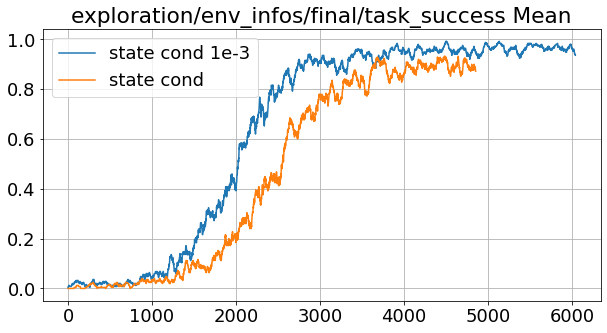

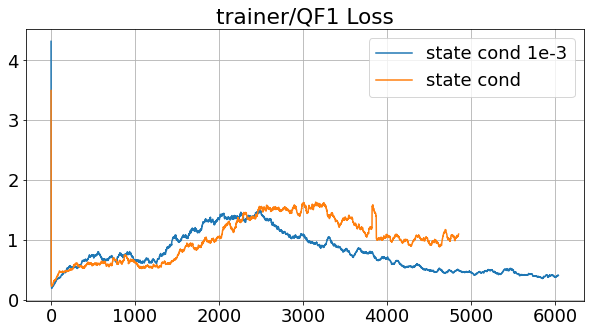

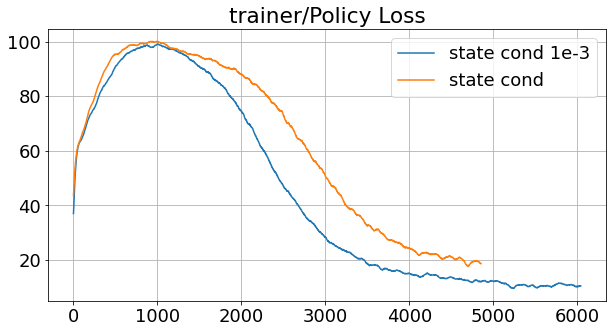

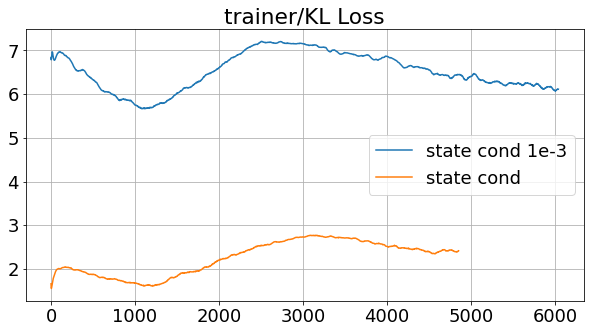

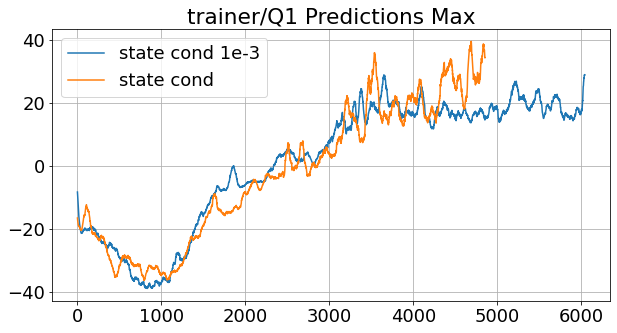

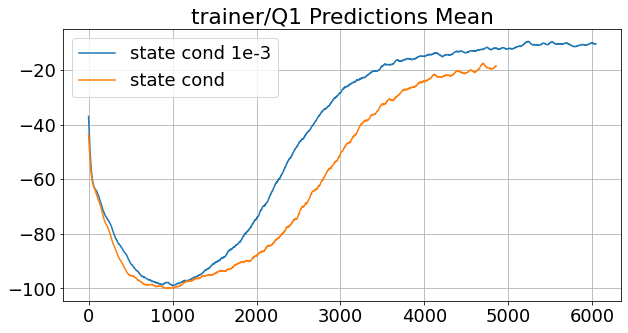

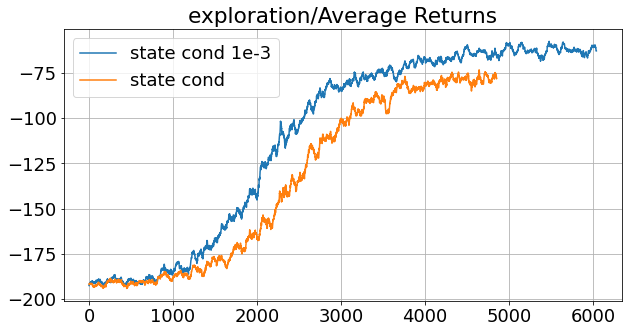

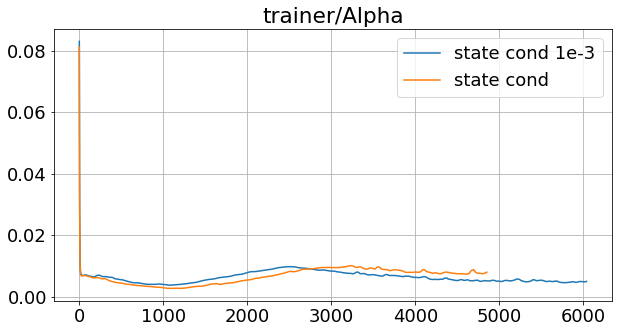

In [471]:
metrics = ['exploration/env_infos/final/task_success Mean', 'trainer/QF1 Loss',
           'trainer/Policy Loss', 'trainer/KL Loss', 'trainer/Q1 Predictions Max', 'trainer/Q1 Predictions Mean',
           'exploration/Average Returns', 'trainer/Alpha']
exps = ['pretrain-sac-valve']
dfs = get_dfs(exps)
window = 50

labels = ['rand ps', 'rand ps longer', 'less rand', 'state cond', 'state cond 1e-3']
indices = [-1, -2]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.title(metric)
    for idx in indices:
        plt.plot(smooth(dfs[idx][metric]), label=labels[idx])
    plt.legend()
    
    plt.grid()
    

Valve success_episodes
                                      mean  std_error
Random Latent (Baseline)          0.081946   0.008650
ASHA w/ Static Input (Ours)       0.920044   0.008330
ASHA w/ Dynamic Input (Ours)      0.285459   0.029443
ASHA w/ Directional Input (Ours)  0.426148   0.081547
Valve block_lengths
                                      mean  std_error
Random Latent (Baseline)          2.572784   0.026708
ASHA w/ Static Input (Ours)       0.138606   0.019277
ASHA w/ Dynamic Input (Ours)      1.805592   0.121334
ASHA w/ Directional Input (Ours)  1.438100   0.262557


/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jensen/miniconda3/envs/CursorControl/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid va

Valve episode_lengths
                                       mean  std_error
Random Latent (Baseline)          192.85325   0.444035
ASHA w/ Static Input (Ours)       104.13900   2.402758
ASHA w/ Dynamic Input (Ours)      186.40800   1.698456
ASHA w/ Directional Input (Ours)  163.77400   9.034497
Valve final_angle_error
                                      mean  std_error
Random Latent (Baseline)          1.639465   0.017522
ASHA w/ Static Input (Ours)       0.204952   0.020671
ASHA w/ Dynamic Input (Ours)      1.085577   0.055822
ASHA w/ Directional Input (Ours)  0.962064   0.166618


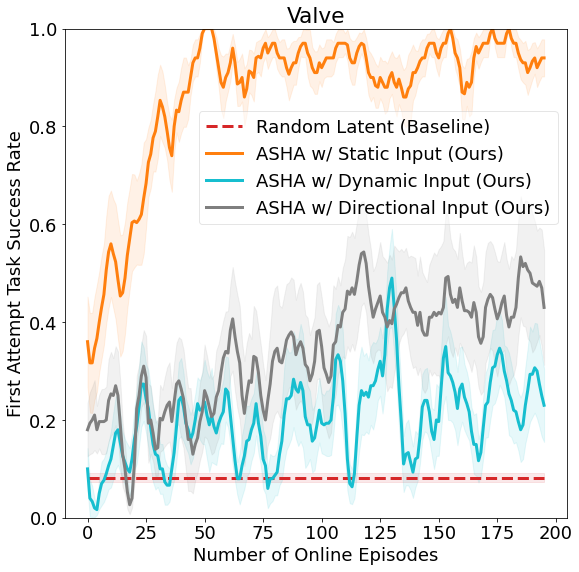

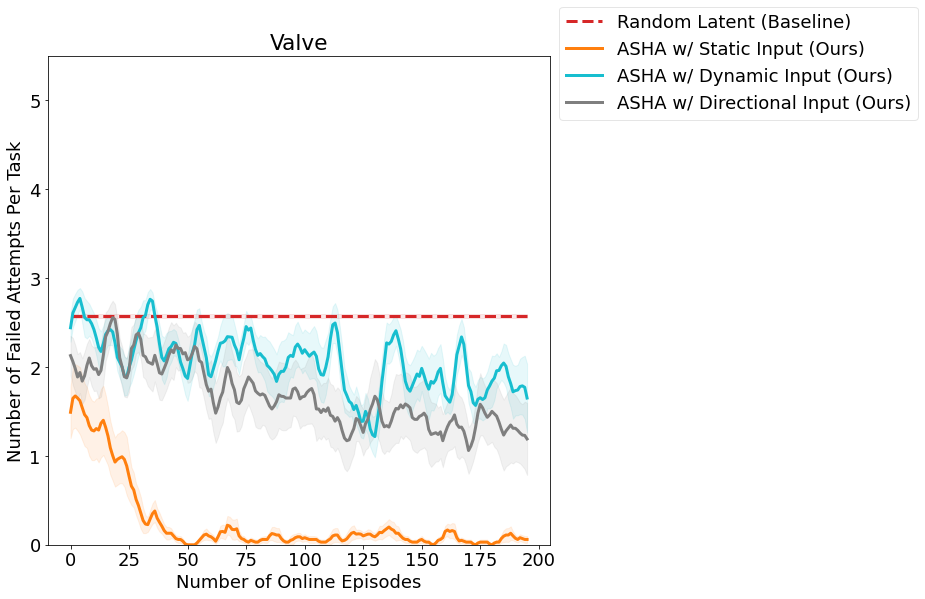

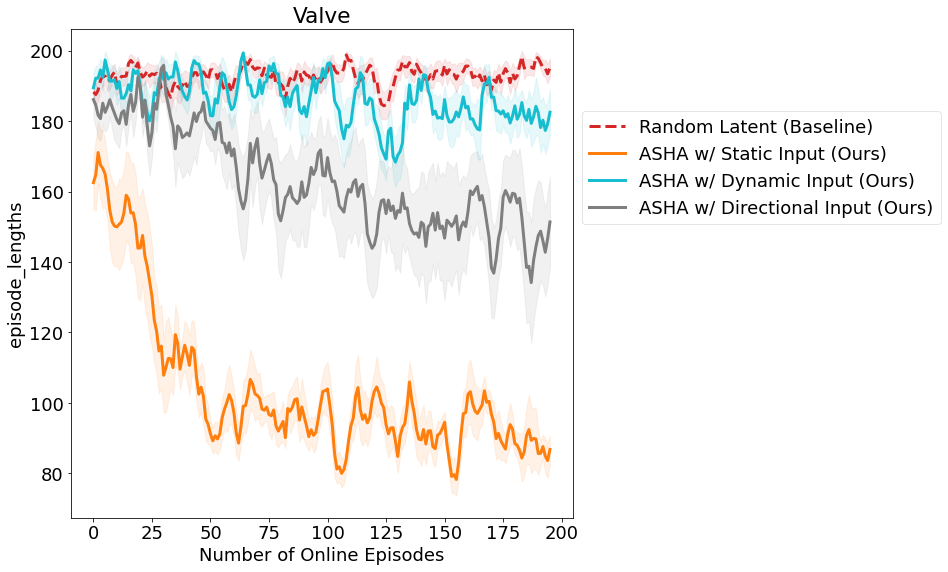

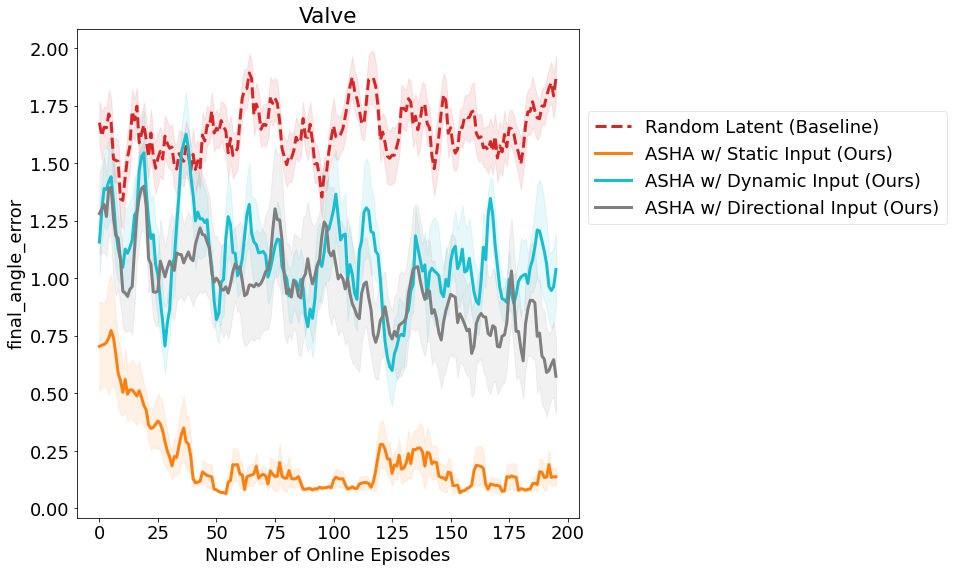

In [1038]:
metrics = ['success_episodes', 'block_lengths', 'episode_lengths', 'final_angle_error']
# exps = ['asha', 'asha-unfreeze', 'asha-no-online', 'asha-goal']

# exps = ['tracking', 'tracking-goal', 'tracking-no-online', 'tracking-kl']


# noise .1 w20 c8 t1
exps = ['goal-baseline-200', 'new-asha-200', 'latent-goal-200', 'new-asha-no-online-200',
        'new-asha-latent-init-200', 'latent-goal-no-online-200']
# exps = ['tracking-latent-init-200', 'tracking-latent-goal-200', 'tracking-goal-baseline-200',
#          'tracking-latent-goal-no-online-200', 'tracking-latent-init-v2-200']

# noise .1 w20 c8 t2
# exps = ['track-latent-init', 'track-goal-baseline', 'track-latent-goal', 'track-latent-goal-no-online']
# exps = ['latent-init', 'latent-goal', 'goal-baseline', 'latent-goal-no-online']

# noise .1 w10 c8 t2
# exps = ['latent-init-w10', 'latent-goal-w10', 'goal-baseline-w10', 'latent-goal-no-online-w10']

# noise .1 w10 c4 t2
# exps = ['latent-init-w10-c4', 'latent-goal-w10-c4', 'goal-baseline-w10', 'latent-goal-no-online-w10-c4']

# noise .3 w10 c8 t2
# exps = ['latent-goal-no-online-w10-n3', 'latent-init-w10-n3', 'latent-goal-w10-n3', 'goal-baseline-w10-n3']
# exps = ['track-latent-goal-no-online-w10-n3', 'track-latent-init-w10-n3', 'track-latent-goal-w10-n3', 'goal-baseline-w10-n3']

# noise .2 w10 c8 t1
# exps = ['latent-goal-no-online-w10-n2-t1', 'latent-init-w10-n2-t1', 'latent-goal-w10-n2-t1', 'goal-baseline-w10-n2-t1']
# exps = ['track-latent-goal-no-online-w10-n2-t1', 'track-latent-init-w10-n2-t1', 'track-latent-goal-w10-n2-t1']

# noise .2 w10 c4 t3
# exps = ['latent-goal-no-online-w10-n2-t3-c4', 'latent-init-w10-n2-t3-c4', 'latent-goal-w10-n2-t3-c4', 
#         'goal-baseline-w10-n2-t3-c4']
# exps = ['track-latent-goal-no-online-w10-n2-t3-c4', 'track-latent-init-w10-n2-t3-c4', 'track-latent-goal-w10-n2-t3-c4', 
#         'track-goal-baseline-w10-n2-t3-c4']

# noise .2 w10 c8 t1 lower online loss
# exps = ['latent-init-w10-n2-t1-s10-l1', 'latent-goal-no-online-w10-n2-t1-s10-l1', 'latent-goal-w10-n2-t1-s10-l1',
#         'goal-baseline-w10-n2-t1-s10-l1']
# exps = ['track-latent-init-w10-n2-t1-s10-l1', 'track-latent-goal-no-online-w10-n2-t1-s10-l1',
#         'track-latent-goal-w10-n2-t1-s10-l1']#, 'track-goal-baseline-w10-n2-t1-s10-l1']


exps = ['asha-valve-50', 'asha-valve-50-track', 'asha-valve-50-dir']
# exps = [exp + '-dir' for exp in exps]
exps = ['rand-valve', 'asha-valve-50', 'asha-valve-50-track', 'asha-valve-50-dir']
names = ['Random Latent (Baseline)', 'ASHA w/ Static Input (Ours)', 'ASHA w/ Dynamic Input (Ours)',
         'ASHA w/ Directional Input (Ours)']

window = 5

results = []
colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:gray', 'tab:brown']
colors = ['tab:red', 'tab:orange', 'tab:cyan',  'tab:gray', ]
for exp, name, color in zip(exps, names, colors):
    results.append((get_metrics(exp), name, color))
    
for metric in metrics:
    title = 'Valve'
    plot(title, metric, *results,
         aux_results=False, font_size=18, ablation=True, figsize=(9, 9), framealpha=.5, legend=True,
         bbox_to_anchor=[1, 0.85])